In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
oofs = [
    "/mnt/storage_dimm2/kaggle_output/icecube-neutrinos-in-deep-ice/20230323-102724/DynEdge/fold_0/oofs.parquet",
    "/mnt/storage_dimm2/kaggle_output/icecube-neutrinos-in-deep-ice/20230409-080525/DynEdge/fold_0/oofs.parquet",
    "/mnt/storage_dimm2/kaggle_output/icecube-neutrinos-in-deep-ice/20230405-063040/GPS/fold_0/oofs.parquet",
]

In [3]:
def angular_dist_score_numpy(az_true, zen_true, az_pred, zen_pred):
    """
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse
    cosine (arccos) thereof is then the angle between the two input vectors

    Parameters:
    -----------

    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian

    Returns:
    --------

    dist : float
        mean over the angular distance(s) in radian
    """

    if not (
        np.all(np.isfinite(az_true))
        and np.all(np.isfinite(zen_true))
        and np.all(np.isfinite(az_pred))
        and np.all(np.isfinite(zen_pred))
    ):
        raise ValueError("All arguments must be finite")

    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)

    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)

    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1 * sz2 * (ca1 * ca2 + sa1 * sa2) + (cz1 * cz2)

    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod = np.clip(scalar_prod, -1, 1)

    # convert back to an angle (in radian)
    return np.average(np.abs(np.arccos(scalar_prod)))

In [4]:
azi, zen = {}, {}

for i, oof in enumerate(oofs):
    df = pd.read_parquet(oof)
    
    azi[f"model_{i}"] = df["azimuth"]
    zen[f"model_{i}"] = df["zenith"]
    

azi = pd.DataFrame(azi).values
zen = pd.DataFrame(zen).values
gt = df[["azimuth_gt", "zenith_gt"]]

In [5]:
def stack(azi, zen, weights=None):
    
    if weights is None:
        dim = azi.shape[1]
        weights = np.ones(dim) / dim
        
    azi_sin = (weights * np.sin(azi)).sum(1)
    azi_cos = (weights * np.cos(azi)).sum(1)
    
    azi_final = np.arctan2(azi_sin, azi_cos)
    zen_final = (weights * zen).sum(1)
    
    return azi_final, zen_final


# Independent weights for azi & zen
def stack_v2(azi, zen, weights=None):
    
    dim = azi.shape[1]
    
    if weights is None:
        weights = np.ones(dim) / dim
        weights = np.concatenate([weights, weights])
        
    weights_a = weights[:dim]
    weights_z = weights[dim:]
        
    azi_sin = (weights_a * np.sin(azi)).sum(1)
    azi_cos = (weights_a * np.cos(azi)).sum(1)
    
    azi_final = np.arctan2(azi_sin, azi_cos)
    zen_final = (weights_z * zen).sum(1)
    
    return azi_final, zen_final


In [6]:
def scorer(weights=None, version=1):
    if version == 2:
        azi_final, zen_final = stack_v2(azi, zen, weights)
#     elif version == 3:
#         azi_final, zen_final = stack_v3(azi, zen, weights)
    else:
        azi_final, zen_final = stack(azi, zen, weights)
    return angular_dist_score_numpy(gt["azimuth_gt"], gt["zenith_gt"], azi_final, zen_final)

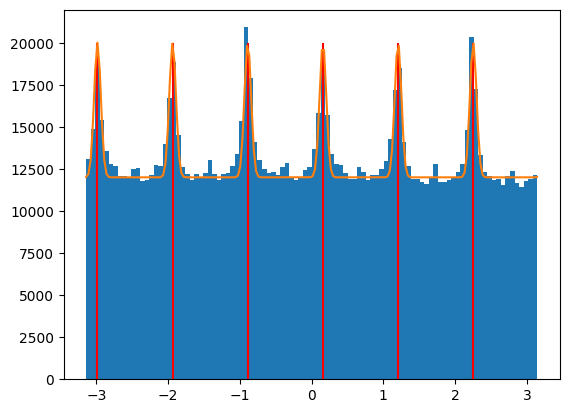

In [7]:
azi_final, zen_final = stack(azi, zen)

plt.hist(azi_final, bins=100)

for i in range(-3, 3):
    plt.vlines(0.15788 + i * np.pi / 3, 0, 20000, colors="r")

x = np.linspace(-np.pi, np.pi, 200)
penalty = np.cos(3 * (x - 0.15788))**50  # Penalty function

plt.plot(x, penalty * 8000 + 12000); # Scale function to fit on top of data

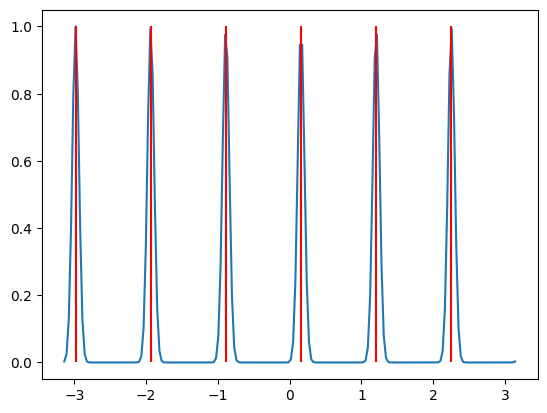

In [8]:
x = np.linspace(-np.pi, np.pi, 200)
plt.plot(x, np.cos(3 * (x - 0.15788))**50)

for i in range(-3,3):
    plt.vlines(0.15788 + i * np.pi / 3, 0, 1, colors="r")

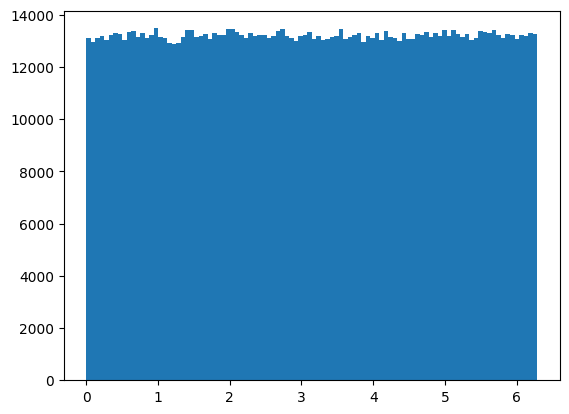

In [9]:
plt.hist(gt["azimuth_gt"], bins=100);

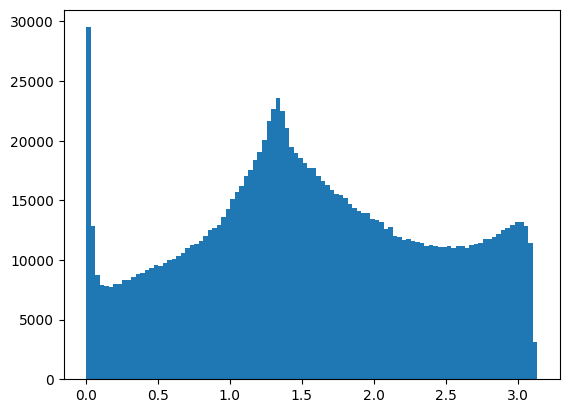

In [10]:
plt.hist(zen_final, bins=100);

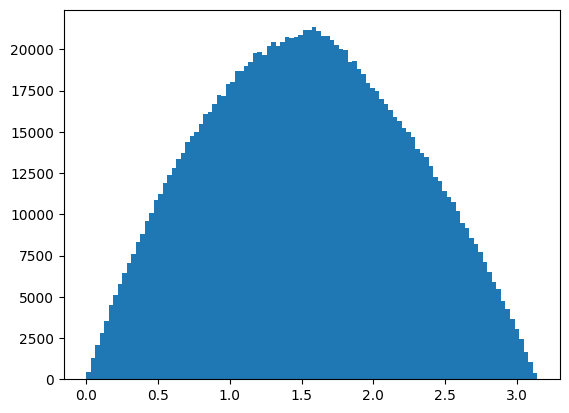

In [11]:
plt.hist(gt["zenith_gt"], bins=100);

In [12]:
scorer()

0.9832772158461447

In [13]:
scorer(version=2)

0.9832772158461447

In [15]:
dim = len(oofs)
weights = np.ones(dim) / dim

In [16]:
# minimize(scorer, weights)

KeyboardInterrupt: 

In [ ]:
# minimize(scorer, np.concatenate([weights, weights]), args=(True,))

# Non-linear

In [4]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [18]:
azi, zen = {}, {}

for i, oof in enumerate(oofs):
    df = pd.read_parquet(oof)
    
#     azi[f"model_{i}"] = df["azimuth"]
#     azi[f"period_{i}"] = np.cos(3 * (df["azimuth"] - 0.15788))**50
    azi[f"sin_{i}"] = np.sin(df["azimuth"])
    azi[f"cos_{i}"] = np.cos(df["azimuth"])
    zen[f"model_{i}"] = df["zenith"]
    

azi = pd.DataFrame(azi)
zen = pd.DataFrame(zen)
gt = df[["azimuth_gt", "zenith_gt"]]

In [22]:
SEED = 48

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
scores = []

for trn_idx, val_idx in  kf.split(azi):
    train_azi_X, train_azi_y = azi.loc[trn_idx], gt.loc[trn_idx, "azimuth_gt"]
    valid_azi_X, valid_azi_y = azi.loc[val_idx], gt.loc[val_idx, "azimuth_gt"]
    
    train_zen_X, train_zen_y = zen.loc[trn_idx], gt.loc[trn_idx, "zenith_gt"]
    valid_zen_X, valid_zen_y = zen.loc[val_idx], gt.loc[val_idx, "zenith_gt"]
    
#     model_azi = RandomForestRegressor(max_depth=10, n_jobs=8, n_estimators=100, random_state=SEED)
    
#     model_azi.fit(train_azi_X, train_azi_y)
    
#     pred_azi = model_azi.predict(valid_azi_X)
    pred_azi = np.arctan2(valid_azi_X[[f"sin_{i}" for i in range(len(oofs))]].sum(1), valid_azi_X[[f"cos_{i}" for i in range(len(oofs))]].sum(1))
    pred_zen = valid_zen_X.mean(1)
    
    score = angular_dist_score_numpy(valid_azi_y, valid_zen_y, pred_azi, pred_zen)
    scores.append(score)
    print(score)
    
print()
print(np.mean(scores))

0.98326313
0.98335034
0.98549736
0.9813704
0.9829047

0.98327714


# PyTorch